In [1]:
!pip install PyMuPDF

import requests
from bs4 import BeautifulSoup
import pandas as pd
import re
import fitz
from tqdm import tqdm
import os

# Get year input from user
start_year = int(input("Enter start year (e.g., 2015): "))
end_year = int(input("Enter end year (e.g., 2025): "))

headers = {'User-Agent': 'Mozilla/5.0'}
base_url = "https://www.federalreserve.gov"
excluded_years = {2020, 2021}
valid_years = set(range(start_year, end_year + 1)) - excluded_years

minutes_data = []

# Part 1: Historical Data
archive_url = f"{base_url}/monetarypolicy/fomc_historical_year.htm"
response = requests.get(archive_url, headers=headers)
soup = BeautifulSoup(response.content, "html.parser")
year_links = soup.find_all('a', href=re.compile(r'fomchistorical20\d{2}.htm'))

filtered_links = []
for link in year_links:
    year = int(re.findall(r'20\d{2}', link['href'])[0])
    if year in valid_years:
        filtered_links.append(f"{base_url}{link['href']}")

print(f"\nFound {len(filtered_links)} historical year pages...\n")

for year_page in tqdm(filtered_links, desc="Scraping Historical Pages"):
    try:
        year_response = requests.get(year_page, headers=headers)
        year_soup = BeautifulSoup(year_response.content, "html.parser")
        meeting_links = year_soup.find_all('a', href=re.compile(r'fomc.*\d{8}\.(htm|pdf)', re.IGNORECASE))

        for link in meeting_links:
            href = link['href']
            full_url = f"{base_url}{href}"
            date_match = re.search(r'(\d{8})', href)

            if date_match:
                date_str = date_match.group(1)
                date = pd.to_datetime(date_str, format='%Y%m%d')
                if date.year not in valid_years:
                    continue

                try:
                    if href.endswith(".htm"):
                        meeting_response = requests.get(full_url)
                        meeting_soup = BeautifulSoup(meeting_response.text, 'html.parser')
                        content_div = meeting_soup.find('div', id='content') or meeting_soup.find('div', class_="col-xs-12 col-sm-8 col-md-8")
                        meeting_content = content_div.get_text(strip=True) if content_div else ""

                    elif href.endswith(".pdf"):
                        pdf_response = requests.get(full_url)
                        with open("temp.pdf", 'wb') as f:
                            f.write(pdf_response.content)
                        pdf_doc = fitz.open("temp.pdf")
                        meeting_content = ""
                        for page in pdf_doc:
                            meeting_content += page.get_text()

                    if meeting_content and len(meeting_content.strip()) > 100:
                        minutes_data.append({
                            "URL": full_url,
                            "Date": date,
                            "Month": date.month,
                            "Year": date.year,
                            "Day": date.day,
                            "Content": meeting_content
                        })

                except Exception as e:
                    print(f"Failed to fetch historical {full_url}: {e}")

    except Exception as e:
        print(f"Failed to open year page {year_page}: {e}")

# Part 2: Main Calendar
calendar_url = f"{base_url}/monetarypolicy/fomccalendars.htm"
resp = requests.get(calendar_url, headers=headers)
soup = BeautifulSoup(resp.content, "html.parser")
calendar_links = soup.find_all('a', href=re.compile(r'fomc.*\d{8}\.(htm|pdf)', re.IGNORECASE))

for link in tqdm(calendar_links, desc="Scraping Calendar Pages"):
    href = link['href']
    full_url = f"{base_url}{href}"
    date_match = re.search(r'(\d{8})', href)
    if date_match:
        date_str = date_match.group(1)
        date = pd.to_datetime(date_str, format='%Y%m%d')
        if date.year not in valid_years:
            continue

        try:
            if href.endswith(".htm"):
                r = requests.get(full_url)
                soup_page = BeautifulSoup(r.text, 'html.parser')
                div = soup_page.find('div', id='content') or soup_page.find('div', class_='col-xs-12 col-sm-8 col-md-8')
                content = div.get_text(strip=True) if div else ""

            elif href.endswith(".pdf"):
                pdf_resp = requests.get(full_url)
                with open("temp.pdf", "wb") as f:
                    f.write(pdf_resp.content)
                pdf_doc = fitz.open("temp.pdf")
                content = ""
                for page in pdf_doc:
                    content += page.get_text()

            if content and len(content.strip()) > 100:
                minutes_data.append({
                    "URL": full_url,
                    "Date": date,
                    "Month": date.month,
                    "Year": date.year,
                    "Day": date.day,
                    "Content": content
                })

        except Exception as e:
            print(f"Failed to fetch calendar {full_url}: {e}")

# Final cleanup and save
if os.path.exists("temp.pdf"):
    os.remove("temp.pdf")

df = pd.DataFrame(minutes_data)
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values(by='Date', ascending=False).reset_index(drop=True)

df.to_csv("fomc_minutes_{}_{}_clean.csv".format(start_year, end_year), index=False, encoding="utf-8")
print(f"\nFinal Dataset: {df.shape[0]} transcripts saved to 'fomc_minutes_{start_year}_{end_year}_clean.csv'")


Enter start year (e.g., 2015): 2015
Enter end year (e.g., 2025): 2025

Found 5 historical year pages...



Scraping Calendar Pages:  45%|████▍     | 75/167 [00:34<00:38,  2.40it/s]

Failed to fetch calendar https://www.federalreserve.govhttps://www.federalreserve.gov/monetarypolicy/fomcpresconf20220316.htm: HTTPSConnectionPool(host='www.federalreserve.govhttps', port=443): Max retries exceeded with url: /www.federalreserve.gov/monetarypolicy/fomcpresconf20220316.htm (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x7dc5224a96d0>: Failed to resolve 'www.federalreserve.govhttps' ([Errno -2] Name or service not known)"))


Scraping Calendar Pages: 100%|██████████| 167/167 [00:48<00:00,  3.45it/s]



Final Dataset: 287 transcripts saved to 'fomc_minutes_2015_2025_clean.csv'


Checked the structure of the data

In [2]:
df.shape

(287, 6)

Length of the articles

In [3]:
len(minutes_data)

287

Data range check


Random sample test


In [4]:
df.sample(10)

,URL,Date,Month,Year,Day,Content
156,https://www.federalreserve.gov/monetarypolicy/...,2018-09-26,9,2018,26,Content last modified 1/12/2024. \n \nPrefator...
155,https://www.federalreserve.gov/monetarypolicy/...,2018-09-26,9,2018,26,Content last modified 1/12/2024. \n \nPrefator...
196,https://www.federalreserve.gov/monetarypolicy/...,2017-07-26,7,2017,26,Content last modified 1/13/2023. \n \nPrefator...
42,https://www.federalreserve.gov/monetarypolicy/...,2023-12-13,12,2023,13,"For release at 2:00 p.m., EST, December 13, 20..."
183,https://www.federalreserve.gov/monetarypolicy/...,2017-12-13,12,2017,13,Content last modified 1/13/2023. \n \nPrefator...
168,https://www.federalreserve.gov/monetarypolicy/...,2018-05-02,5,2018,2,Content last modified 1/12/2024. \n \nPrefator...
247,https://www.federalreserve.gov/monetarypolicy/...,2016-01-27,1,2016,27,\n \n \n \n \n \n \n \n \n \n \n \n \n \n \...
3,https://www.federalreserve.gov/monetarypolicy/...,2025-03-19,3,2025,19,FOMC\nFEDERAL RESERV E SYSTEM\nMinutes of the ...
111,https://www.federalreserve.gov/monetarypolicy/...,2019-10-30,10,2019,30,Minutes of the Federal Open Market Committee \...
167,https://www.federalreserve.gov/monetarypolicy/...,2018-05-02,5,2018,2,HomeMonetary PolicyFederal Open Market Committ...


First 10 Rows in Ascending Date Order

In [5]:
df_sorted_asc = df.sort_values(by='Date', ascending=True).reset_index(drop=True)
df_sorted_asc.head(10)


,URL,Date,Month,Year,Day,Content
0,https://www.federalreserve.gov/monetarypolicy/...,2015-01-28,1,2015,28,Minutes of the Federal Open Market Committee \...
1,https://www.federalreserve.gov/monetarypolicy/...,2015-01-28,1,2015,28,Content last modified 01/08/2021. \nPrefatory ...
2,https://www.federalreserve.gov/monetarypolicy/...,2015-01-28,1,2015,28,HomeMonetary PolicyFederal Open Market Committ...
3,https://www.federalreserve.gov/monetarypolicy/...,2015-01-28,1,2015,28,Content last modified 01/08/2021. \nPrefatory ...
4,https://www.federalreserve.gov/monetarypolicy/...,2015-03-18,3,2015,18,HomeMonetary PolicyFederal Open Market Committ...
5,https://www.federalreserve.gov/monetarypolicy/...,2015-03-18,3,2015,18,Content last modified 01/08/2021. \nPrefatory ...
6,https://www.federalreserve.gov/monetarypolicy/...,2015-03-18,3,2015,18,Minutes of the Federal Open Market Committee \...
7,https://www.federalreserve.gov/monetarypolicy/...,2015-03-18,3,2015,18,HomeMonetary PolicyFederal Open Market Committ...
8,https://www.federalreserve.gov/monetarypolicy/...,2015-03-18,3,2015,18,Content last modified 01/08/2021. \nPrefatory ...
9,https://www.federalreserve.gov/monetarypolicy/...,2015-04-29,4,2015,29,Content last modified 01/08/2021. \nPrefatory ...


Last 10 Rows in Ascending Date Order

In [6]:
df_sorted_asc.tail(10)


,URL,Date,Month,Year,Day,Content
277,https://www.federalreserve.gov/monetarypolicy/...,2024-12-18,12,2024,18,HomeMonetary PolicyFederal Open Market Committ...
278,https://www.federalreserve.gov/monetarypolicy/...,2024-12-18,12,2024,18,"For release at 2:00 p.m., EST, December 18, 20..."
279,https://www.federalreserve.gov/monetarypolicy/...,2025-01-29,1,2025,29,HomeMonetary PolicyFederal Open Market Committ...
280,https://www.federalreserve.gov/monetarypolicy/...,2025-01-29,1,2025,29,\n \n \nFOMC\n \n \n \nFEDERAL RESERVE SYSTEM...
281,https://www.federalreserve.gov/monetarypolicy/...,2025-01-29,1,2025,29,Please enable JavaScript if it is disabled in ...
282,https://www.federalreserve.gov/monetarypolicy/...,2025-03-19,3,2025,19,HomeMonetary PolicyFederal Open Market Committ...
283,https://www.federalreserve.gov/monetarypolicy/...,2025-03-19,3,2025,19,FOMC\nFEDERAL RESERV E SYSTEM\nMinutes of the ...
284,https://www.federalreserve.gov/monetarypolicy/...,2025-03-19,3,2025,19,HomeMonetary PolicyFederal Open Market Committ...
285,https://www.federalreserve.gov/monetarypolicy/...,2025-03-19,3,2025,19,"For release at 2:00 p.m., EDT, March 19, 2025\..."
286,https://www.federalreserve.gov/monetarypolicy/...,2025-03-19,3,2025,19,HomeMonetary PolicyFederal Open Market Committ...


In [7]:
print("Date Range:", df_sorted_asc['Date'].min(), "→", df_sorted_asc['Date'].max())


Date Range: 2015-01-28 00:00:00 → 2025-03-19 00:00:00


In [8]:
import string
from wordcloud import STOPWORDS

def calc_snr_ratio(text):
    words = text.split()
    if not words:
        return 0
    unique = len(set(words))
    total = len(words)
    return unique / (total + 1e-5)

def calc_stopword_ratio(text):
    words = text.split()
    if not words:
        return 0
    stop_count = sum(1 for word in words if word.lower() in STOPWORDS)
    return stop_count / len(words)

def calc_redundancy_ratio(text):
    words = text.split()
    if not words:
        return 0
    return 1 - (len(set(words)) / len(words))

def calc_special_char_density(text):
    specials = [char for char in text if char in string.punctuation]
    return len(specials) / (len(text) + 1e-5)


In [9]:
df_noise = df.copy()
df_noise = df_noise[['Date', 'Content']].dropna().copy()

df_noise['SNR_Ratio'] = df_noise['Content'].apply(calc_snr_ratio)
df_noise['StopWord_Ratio'] = df_noise['Content'].apply(calc_stopword_ratio)
df_noise['Redundancy_Ratio'] = df_noise['Content'].apply(calc_redundancy_ratio)
df_noise['SpecialChar_Density'] = df_noise['Content'].apply(calc_special_char_density)


In [10]:
df_plot = df_noise.sort_values(by="Date", ascending=False).head(10).sort_values(by="Date")
2

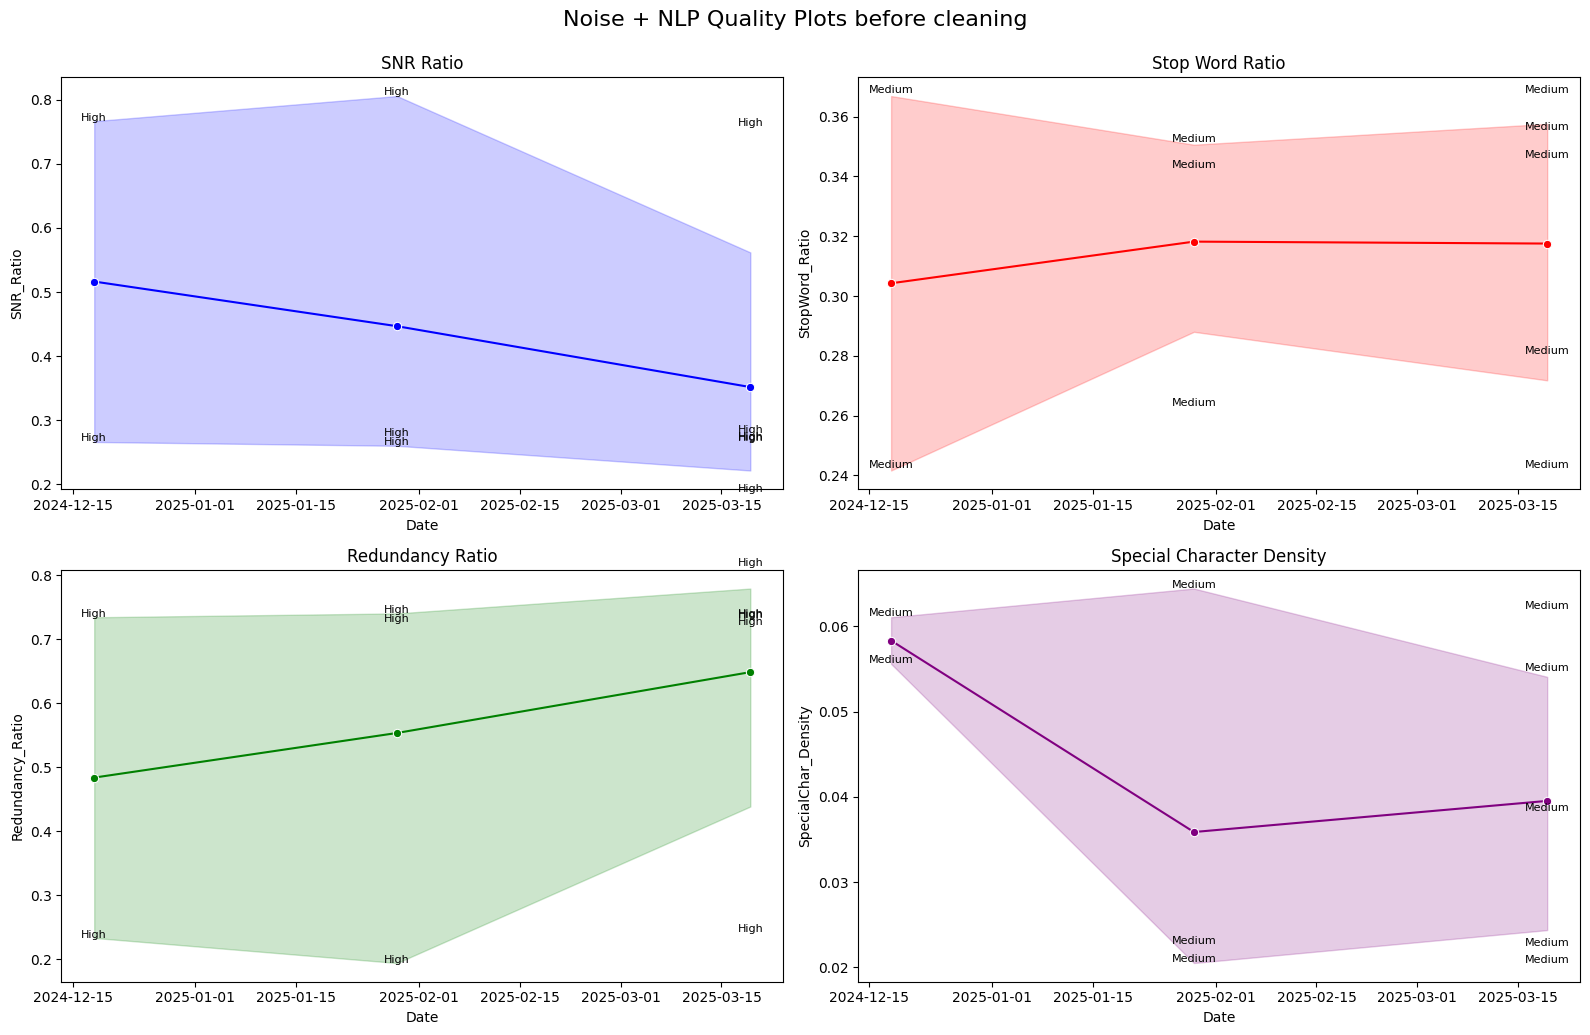

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axs = plt.subplots(2, 2, figsize=(16, 10))

# Plot 1: SNR
sns.lineplot(data=df_plot, x="Date", y="SNR_Ratio", marker='o', ax=axs[0, 0], color='blue')
axs[0, 0].set_title("SNR Ratio")
for i, val in enumerate(df_plot['SNR_Ratio']):
    axs[0, 0].text(df_plot['Date'].iloc[i], val + 0.001, "High", ha='center', fontsize=8)

# Plot 2: Stop Word Ratio
sns.lineplot(data=df_plot, x="Date", y="StopWord_Ratio", marker='o', ax=axs[0, 1], color='red')
axs[0, 1].set_title("Stop Word Ratio")
for i, val in enumerate(df_plot['StopWord_Ratio']):
    axs[0, 1].text(df_plot['Date'].iloc[i], val + 0.001, "Medium", ha='center', fontsize=8)

# Plot 3: Redundancy
sns.lineplot(data=df_plot, x="Date", y="Redundancy_Ratio", marker='o', ax=axs[1, 0], color='green')
axs[1, 0].set_title("Redundancy Ratio")
for i, val in enumerate(df_plot['Redundancy_Ratio']):
    axs[1, 0].text(df_plot['Date'].iloc[i], val + 0.0005, "High", ha='center', fontsize=8)

# Plot 4: Special Characters
sns.lineplot(data=df_plot, x="Date", y="SpecialChar_Density", marker='o', ax=axs[1, 1], color='purple')
axs[1, 1].set_title("Special Character Density")
for i, val in enumerate(df_plot['SpecialChar_Density']):
    axs[1, 1].text(df_plot['Date'].iloc[i], val + 0.0001, "Medium", ha='center', fontsize=8)

plt.tight_layout()
plt.suptitle("Noise + NLP Quality Plots before cleaning", fontsize=16, y=1.03)
plt.show()


In [12]:
def calc_semantic_density(text):
    words = text.split()
    return len(set(words)) / (len(text.split()) + 1e-5)

def calc_digit_ratio(text):
    digits = [char for char in text if char.isdigit()]
    return len(digits) / (len(text) + 1e-5)

def calc_noise_score(row):
    return (
        row['StopWord_Ratio'] +
        row['Redundancy_Ratio'] +
        row['SpecialChar_Density']
    ) / 3

def calc_quality_score(row):
    return 1 - row['Noise_Score']


In [13]:
df_noise['Semantic_Density'] = df_noise['Content'].apply(calc_semantic_density)
df_noise['Digit_Ratio'] = df_noise['Content'].apply(calc_digit_ratio)
df_noise['Noise_Score'] = df_noise.apply(calc_noise_score, axis=1)
df_noise['Quality_Score'] = df_noise.apply(calc_quality_score, axis=1)

# Prepare 10 rows to plot
df_plot2 = df_noise.sort_values(by="Date", ascending=False).head(10).sort_values(by="Date")


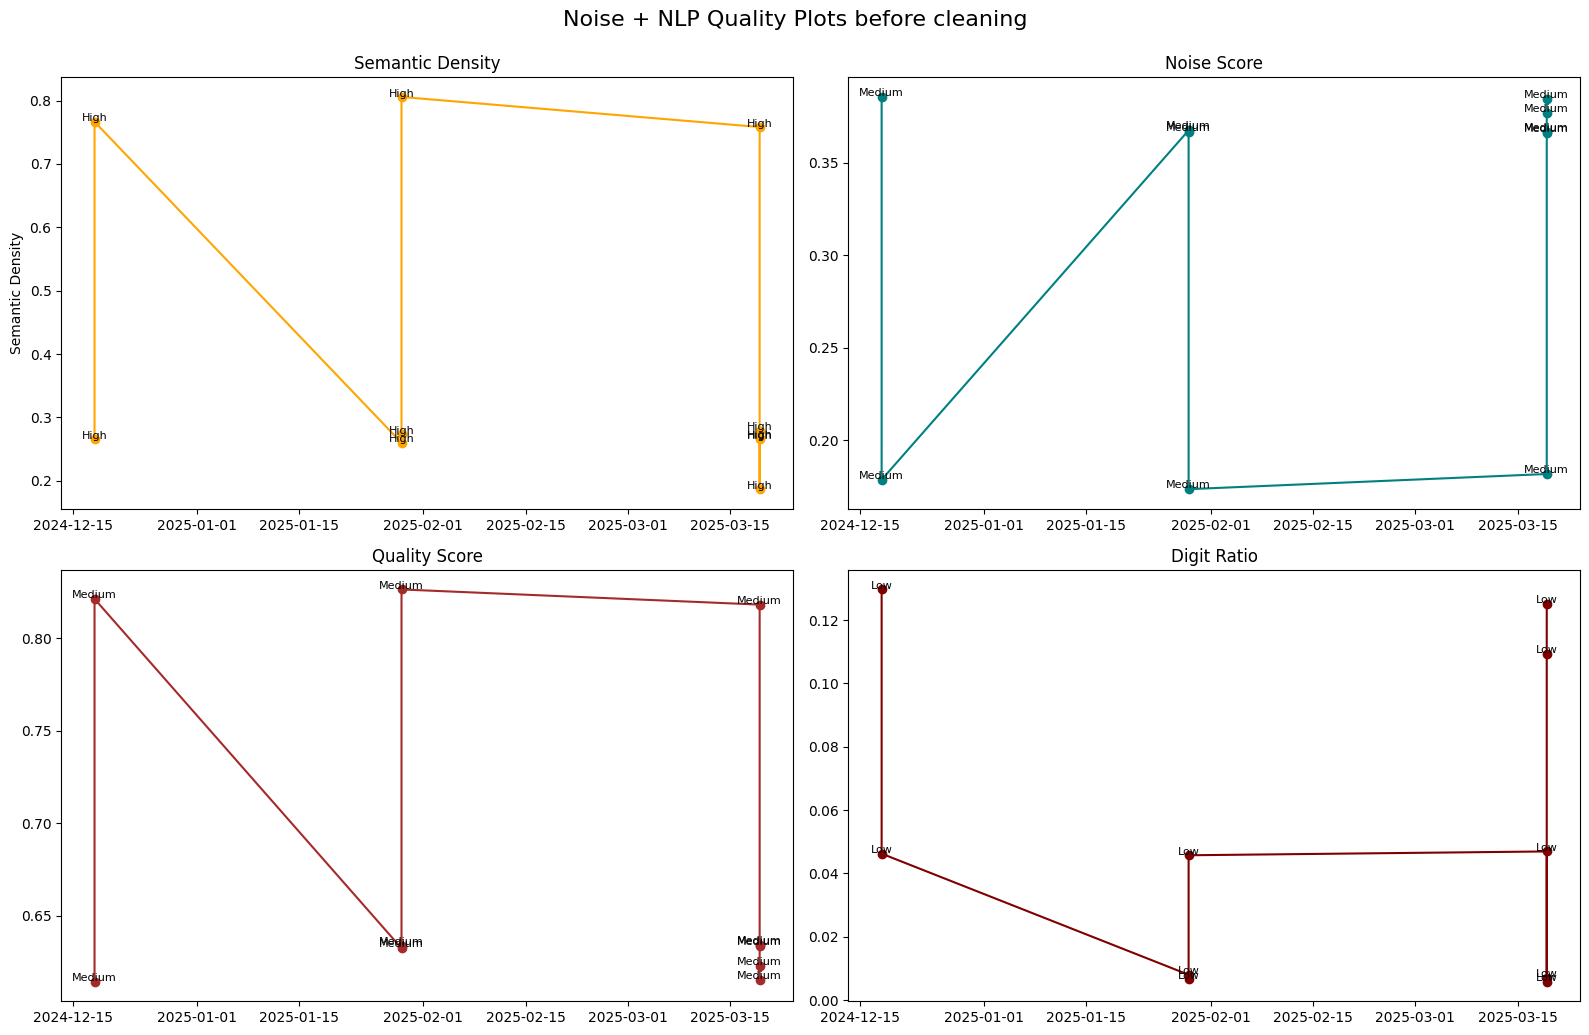

In [14]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 2, figsize=(16, 10))

# Semantic Density
axs[0, 0].plot(df_plot2['Date'], df_plot2['Semantic_Density'], marker='o', color='orange')
axs[0, 0].set_title("Semantic Density")
axs[0, 0].set_ylabel("Semantic Density")
for i, val in enumerate(df_plot2['Semantic_Density']):
    axs[0, 0].text(df_plot2['Date'].iloc[i], val + 0.0005, "High", ha='center', fontsize=8)

# Noise Score
axs[0, 1].plot(df_plot2['Date'], df_plot2['Noise_Score'], marker='o', color='teal')
axs[0, 1].set_title("Noise Score")
for i, val in enumerate(df_plot2['Noise_Score']):
    axs[0, 1].text(df_plot2['Date'].iloc[i], val + 0.0005, "Medium", ha='center', fontsize=8)

# Quality Score
axs[1, 0].plot(df_plot2['Date'], df_plot2['Quality_Score'], marker='o', color='brown')
axs[1, 0].set_title("Quality Score")
for i, val in enumerate(df_plot2['Quality_Score']):
    axs[1, 0].text(df_plot2['Date'].iloc[i], val + 0.0005, "Medium", ha='center', fontsize=8)

# Digit Ratio
axs[1, 1].plot(df_plot2['Date'], df_plot2['Digit_Ratio'], marker='o', color='maroon')
axs[1, 1].set_title("Digit Ratio")
for i, val in enumerate(df_plot2['Digit_Ratio']):
    axs[1, 1].text(df_plot2['Date'].iloc[i], val + 0.0001, "Low", ha='center', fontsize=8)

plt.tight_layout()
plt.suptitle("Noise + NLP Quality Plots before cleaning", fontsize=16, y=1.03)
plt.show()
